<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/page_satus_dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 0s (8,938 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 

In [2]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

Using TensorFlow backend.


In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
data		  keras_model.hdf5  page_st.csv
error.csv	  keras_model.json  text_token.pickle
error_domain.csv  logs		    weights.best.h5


In [54]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df2 = pd.read_csv(base_dir + 'new_status.csv',sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df = pd.concat([raw_df,raw_df2],axis=0)
raw_df = raw_df[~raw_df.duplicated()]
samples = len(raw_df)
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())

raw_df.to_csv(base_dir+'page_st.csv',index=False)

raw_df (2452, 3)
Index(['label', 'url', 'text'], dtype='object')
no        1463
stock      692
list       139
top         96
block       25
login       25
except      12
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [7]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


no       1760
stock     692
Name: label, dtype: int64
raw_df (2452, 3)
Index(['label', 'url', 'text'], dtype='object')


In [46]:
text = 'sorry sorry sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock sold out切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  text = re.sub('\s+',' ',text)
  words = text.lower()
  return words
print(prepro(text))

def find_at(text:str)->int:
  match = re.search('(sold out|out of stock|在庫切れ|在庫なし)',text)
  if match:
    return match.start()
  else:
    return 0
print(find_at(text))
  


sorry sorry sorry we can t this product page re sold out 404 whoops our bad it gone out of stock sold out 切れ 在庫 なし 完売 まし た 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん 
50


In [58]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['start'] = raw_df['text'].apply(lambda x : find_at(x))
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
start = raw_df['start'].reshape(samples,1)
print('flag',flag.shape,'start',start.shape,'X',X.shape)
# X = np.concatenate((flag,X),axis=1)
X = np.concatenate((start,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))

print('X',X.shape)

flag (2452, 1) start (2452, 1) X (2452, 250)
word_count 27729
X (2452, 251)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}


In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1
raw_df['true'] = raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0)
y = to_categorical(raw_df['true'].values)
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [62]:

def get_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(1500, 64, input_length= len(X[0])))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(512,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(512,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(256,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['categorical_accuracy'])
  return model

get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 251, 64)           96000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 251, 64)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16064)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16064)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               8225280   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total para

In [65]:

EPOCHS = 50
BATCH_SIZE = 32

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce]

scores = []
historys = []
maxs = []
kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  model = get_model()
  history = model.fit(X[train_index], y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
  historys.append(history)
  maxs.append(np.array(history.history['val_categorical_accuracy']).max())
  score = model.evaluate(X[test_index],y[test_index])
  print(score)
  scores.append(score)

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(X[test_index],y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])
print('maxs',maxs)
print('mean',np.array(maxs).mean())
print('std',np.array(maxs).std())

613/613 [==============================] - 0s 109us/step
[2.2029902440105964, 0.6133768352365416]
613/613 [==============================] - 0s 111us/step
[0.15452699531001235, 0.9608482871125612]
613/613 [==============================] - 0s 114us/step
[0.14224526968778553, 0.965742251223491]
613/613 [==============================] - 0s 108us/step
[0.4223328316812122, 0.8923327896081604]
613/613 [==============================] - 1s 876us/step
Test best loss: 0.4589573781797586
Test best accuracy: 0.8694942904238211
maxs [0.6304347826086957, 0.875, 0.8641304347826086, 0.9809782608695652]
mean 0.8376358695652175
std 0.1280403957839272


In [20]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)
print("Std",pd.DataFrame(scores).std()[1]*100)


KFlod
Sample 2452
Score 94.0456770032304
Std 1.5447387417319678


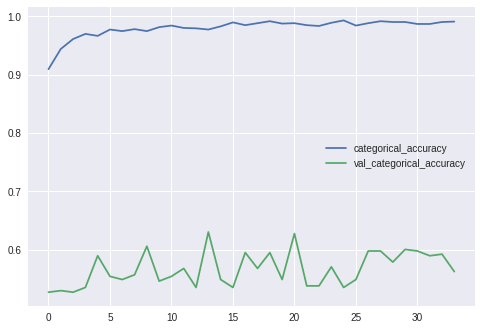

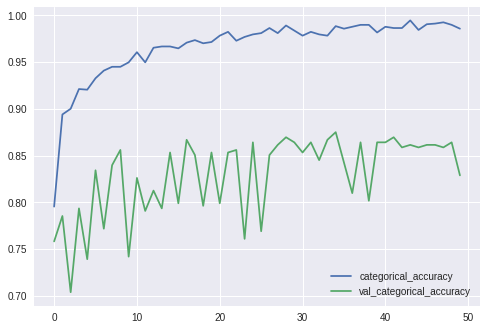

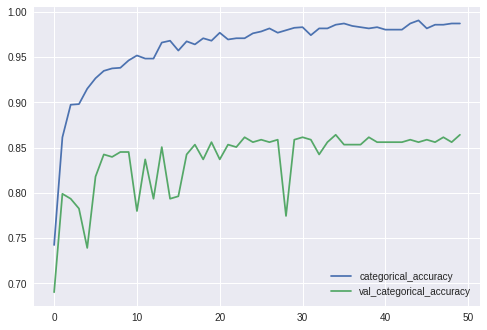

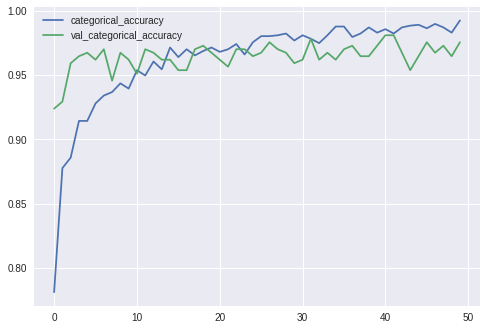

In [66]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


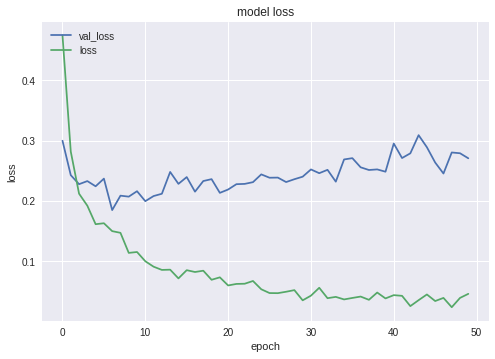

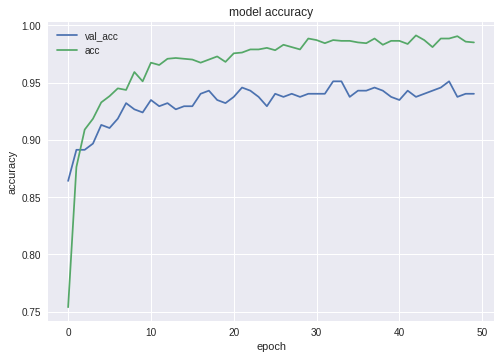

In [16]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [17]:
len(test_index)

613

In [0]:
raw_df['pred'] = load_model.predict(X).argmax(axis=1)

In [19]:
error_df = raw_df.query("true != pred")
print(len(error_df))
error_df[['label','true','pred','url','text']].to_csv(base_dir+'error.csv',index=False)

67
